## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Needed libraries

In [2]:
import glob

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt

import scipy.io

from scipy.io import loadmat
import scipy.signal

%matplotlib inline

### Provided code

In [3]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # HIGH_Hzer confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


### Student code:

In [4]:
# set the sampling rate to 125Hz
fs = 125

# use the 40-240BPM range to create your pass band
LOW_BPM, HIGH_BPM = 40, 240
LOW_Hz, HIGH_Hz = LOW_BPM/60 , HIGH_BPM/60

# window sizes in seconds:
window_length_s  = 8  
window_shift_s = 2 

# transform to data points:
window_length = window_length_s * fs
window_shift = window_shift_s * fs

overlap = 6

In [5]:
def ground_truth(ref_fl):
    """ loads the ground truth values    
    args:
        ref_fl: Name of the .mat file that contains reference data    
    Returns:
        A numpy array of the ground truth values for the input ref_fl
    """
    target = sp.io.loadmat(ref_fl)['BPM0']    
    return target

def bandpass_filter(signal, LOW_Hz, HIGH_Hz,  fs):
    """Bandpass Filter.
    
    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate of <signal>
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, (LOW_Hz, HIGH_Hz), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def Featurize(signal, fs):
    """
    A featurization of the accelerometer signal.
    Args:
        signal: (np.array) The input signal             
        fs: (number) The sampling rate of <signal>      
    Returns: 
         n-tuple of accelerometer features
    """ 

    # fft of ppg signal
    fft_len = 2*len(signal)
    
    # Create an array of frequency bins
    freqs = np.fft.rfftfreq(fft_len, 1 / fs)
    
    # Take an FFT of the centered signal
    fft = np.abs(np.fft.rfft(signal - np.mean(signal), fft_len))
    
    # Filter fft between low_bpm and high_pbm after narwing the range
    fft[freqs <= (LOW_BPM + 20)/60] = 0.0 
    fft[freqs >= (HIGH_BPM - 60)/60] = 0.0
    
    # signal mean  and energy
    mean = np.mean(signal)
    energy = np.sum(np.square(signal - mean))
    
    return freqs, fft, energy 


def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # load the ground truth    
    target = ground_truth(ref_fl)
    
    # filter signals
    ppg  = bandpass_filter(ppg, LOW_Hz, HIGH_Hz, fs)
    accx = bandpass_filter(accx, LOW_Hz, HIGH_Hz, fs)
    accy = bandpass_filter(accy, LOW_Hz, HIGH_Hz, fs)
    accz = bandpass_filter(accz, LOW_Hz, HIGH_Hz, fs)
    
    # calculate acc from (x,y,z)
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    # compute pulse rates
    
    est, confidence = [],[]
   
    for i in range(0, len(ppg) - window_length, window_shift):
        
        ppg_freqs, ppg_fft, ppg_energy = Featurize(ppg[i:i+window_length], fs)
        acc_freqs, acc_fft, acc_energy = Featurize(acc[i:i+window_length], fs)

        max_ppg = ppg_freqs[np.argmax(ppg_energy)]
        max_acc = acc_freqs[np.argmax(acc_energy)]
        
        j = 1        
        while np.abs(max_ppg - max_acc) <= 0 and j <=2:
            j += 1
            max_ppg = ppg_freqs[np.argsort(ppg_fft, axis = 0)[-j]]
            max_acc = acc_freqs[np.argsort(acc_fft, axis = 0)[-j]]

        est_freqs = max_ppg
        est.append(est_freqs *60)
        
        # compute confidence
        conf = np.sum(ppg_fft[(ppg_freqs >= (est_freqs - LOW_Hz)) & (ppg_freqs <= (est_freqs + LOW_Hz))])/ np.sum(ppg_fft)                
        confidence.append(conf) 
        
        # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors = np.abs(np.diag(est - target))
    return errors, np.array(confidence)

In [5]:
data_fls, ref_fls = LoadTroikaDataset()

In [6]:
sample_index = 4

sample_ppg, sample_accx, sample_accy, sample_accz = LoadTroikaDataFile(data_fls[sample_index]) 

filtered_sample_ppg  = bandpass_filter(sample_ppg, LOW_Hz, HIGH_Hz, fs)
filtered_sample_accx = bandpass_filter(sample_accx, LOW_Hz, HIGH_Hz, fs)
filtered_sample_accy = bandpass_filter(sample_accy, LOW_Hz, HIGH_Hz, fs)
filtered_sample_accz = bandpass_filter(sample_accz, LOW_Hz, HIGH_Hz, fs)
filtered_acc = np.sqrt(filtered_sample_accx**2 + filtered_sample_accy**2 + filtered_sample_accz**2)

labels = ground_truth(ref_fls[sample_index])

print("Shape of ppg signal : ", sample_ppg.shape)
print("Shape of accx signal: ", sample_accx.shape)
print("Shape of accy signal: ", sample_accy.shape)
print("Shape of accz signal: ", sample_accz.shape)
print("Shape of ground truth:", labels.shape)

Shape of ppg signal :  (37250,)
Shape of accx signal:  (37250,)
Shape of accy signal:  (37250,)
Shape of accz signal:  (37250,)
Shape of ground truth: (146, 1)


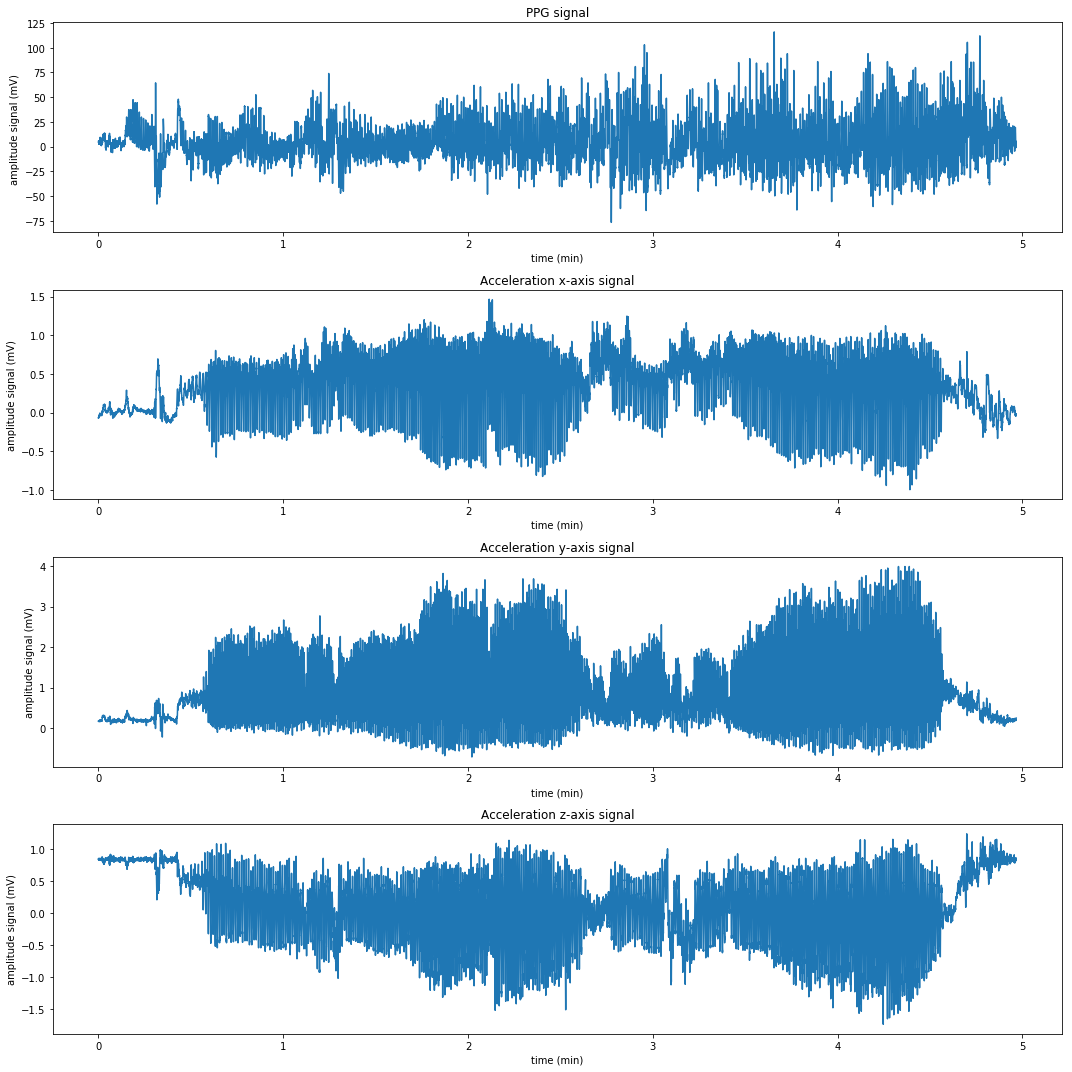

In [20]:
ts = np.arange(0, len(sample_ppg), 1) / fs /60

fig, axs = plt.subplots(4, figsize=(15, 15))
axs[0].plot(ts, sample_ppg)
axs[0].set_xlabel('time (min)')
axs[0].set_ylabel('amplitude signal (mV) ')
axs[0].set_title('PPG signal')

axs[1].plot(ts, sample_accx)
axs[1].set_xlabel('time (min)')
axs[1].set_ylabel('amplitude signal (mV)')
axs[1].set_title('Acceleration x-axis signal')

axs[2].plot(ts, sample_accy)
axs[2].set_xlabel('time (min)')
axs[2].set_ylabel('amplitude signal (mV)')
axs[2].set_title('Acceleration y-axis signal')

axs[3].plot(ts, sample_accz)
axs[3].set_xlabel('time (min)')
axs[3].set_ylabel('amplitude signal (mV)')
axs[3].set_title('Acceleration z-axis signal')

plt.tight_layout()
plt.show()

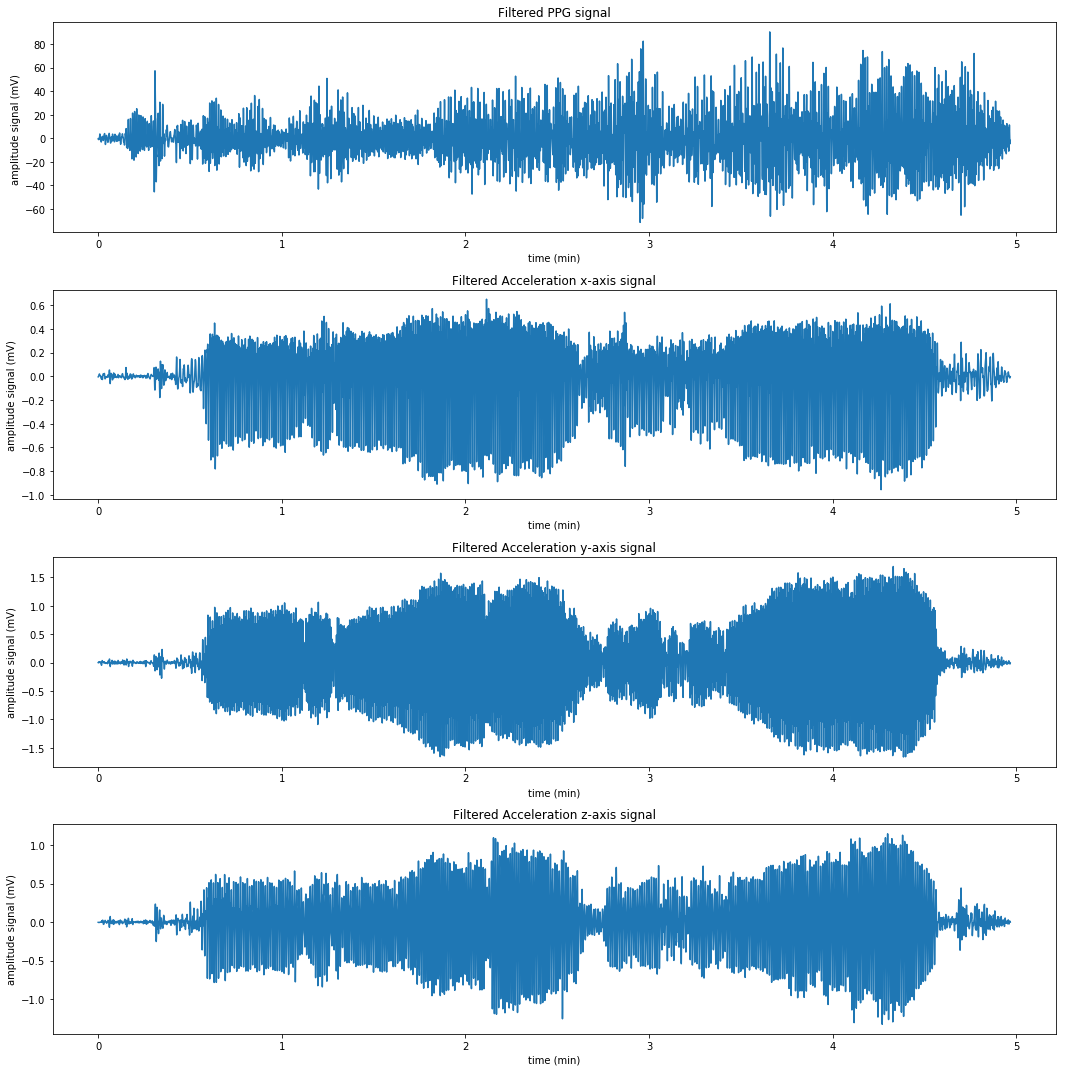

In [21]:
ts = np.arange(0, len(sample_ppg), 1) / fs /60

fig, axs = plt.subplots(4, figsize=(15, 15))
axs[0].plot(ts, filtered_sample_ppg)
axs[0].set_xlabel('time (min)')
axs[0].set_ylabel('amplitude signal (mV) ')
axs[0].set_title('Filtered PPG signal')

axs[1].plot(ts, filtered_sample_accx)
axs[1].set_xlabel('time (min)')
axs[1].set_ylabel('amplitude signal (mV)')
axs[1].set_title('Filtered Acceleration x-axis signal')

axs[2].plot(ts, filtered_sample_accy)
axs[2].set_xlabel('time (min)')
axs[2].set_ylabel('amplitude signal (mV)')
axs[2].set_title('Filtered Acceleration y-axis signal')

axs[3].plot(ts, filtered_sample_accz)
axs[3].set_xlabel('time (min)')
axs[3].set_ylabel('amplitude signal (mV)')
axs[3].set_title('Filtered Acceleration z-axis signal')

plt.tight_layout()
plt.show()

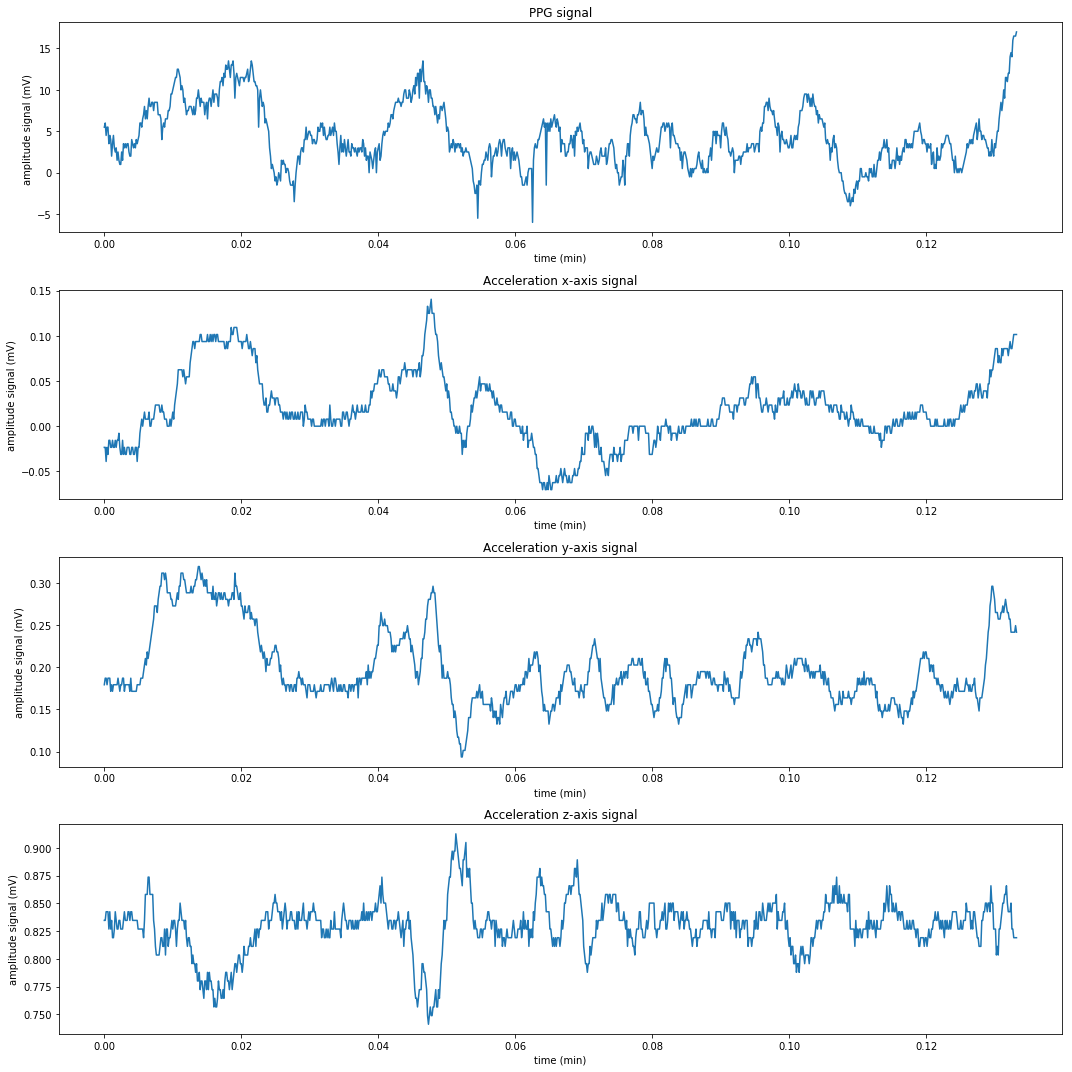

In [27]:
i=100
ts = np.arange(0, len(filtered_sample_ppg[i : i+window_length]), 1) / fs /60

fig, axs = plt.subplots(4, figsize=(15, 15))
axs[0].plot(ts, sample_ppg[i:i+window_length])
axs[0].set_xlabel('time (min)')
axs[0].set_ylabel('amplitude signal (mV) ')
axs[0].set_title('PPG signal')

axs[1].plot(ts, sample_accx[i:i+window_length])
axs[1].set_xlabel('time (min)')
axs[1].set_ylabel('amplitude signal (mV)')
axs[1].set_title('Acceleration x-axis signal')

axs[2].plot(ts, sample_accy[i:i+window_length])
axs[2].set_xlabel('time (min)')
axs[2].set_ylabel('amplitude signal (mV)')
axs[2].set_title('Acceleration y-axis signal')

axs[3].plot(ts, sample_accz[i:i+window_length])
axs[3].set_xlabel('time (min)')
axs[3].set_ylabel('amplitude signal (mV)')
axs[3].set_title('Acceleration z-axis signal')

plt.tight_layout()
plt.show()

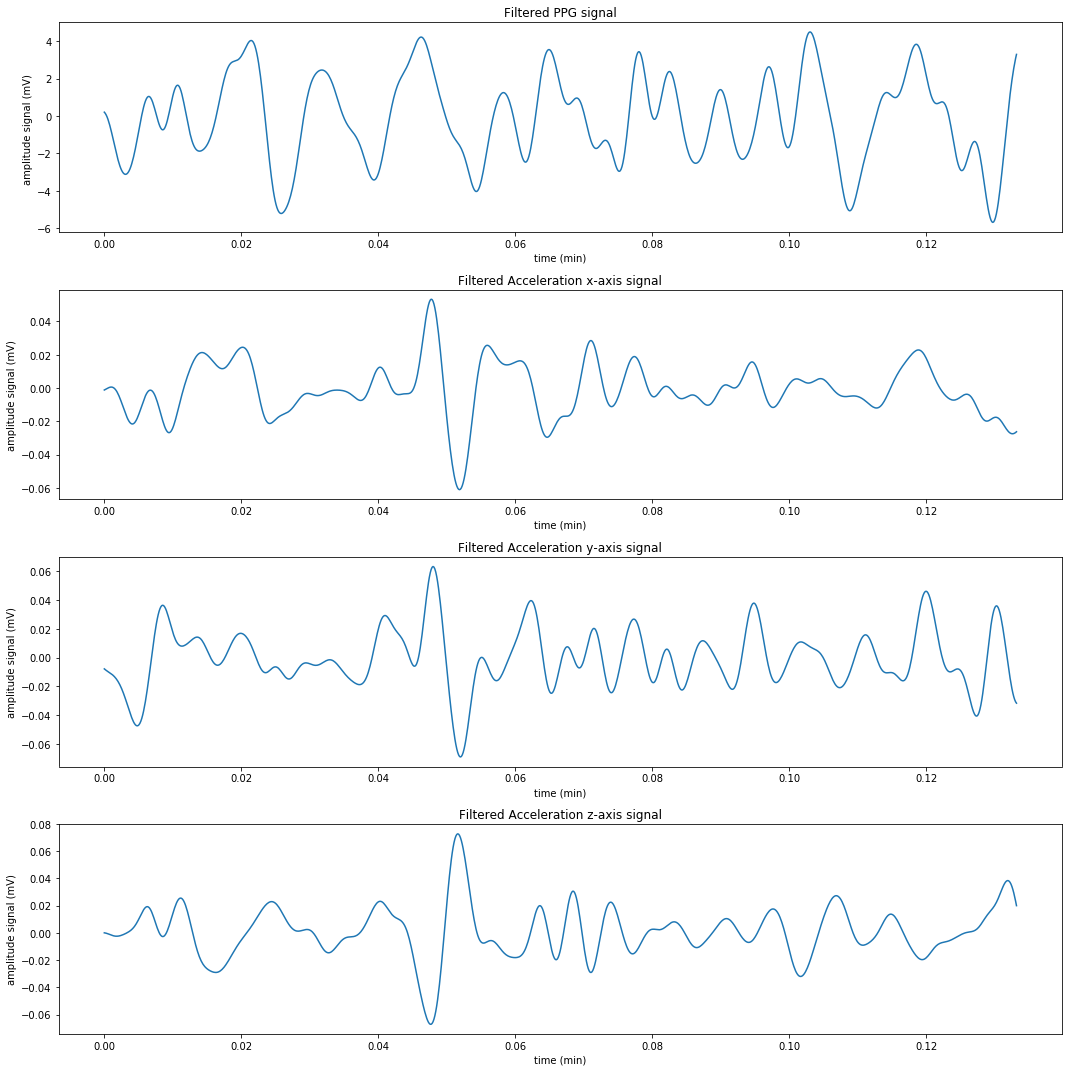

In [28]:
i=100
ts = np.arange(0, len(filtered_sample_ppg[i : i+window_length]), 1) / fs /60

fig, axs = plt.subplots(4, figsize=(15, 15))
axs[0].plot(ts, filtered_sample_ppg[i:i+window_length])
axs[0].set_xlabel('time (min)')
axs[0].set_ylabel('amplitude signal (mV) ')
axs[0].set_title('Filtered PPG signal')

axs[1].plot(ts, filtered_sample_accx[i:i+window_length])
axs[1].set_xlabel('time (min)')
axs[1].set_ylabel('amplitude signal (mV)')
axs[1].set_title('Filtered Acceleration x-axis signal')

axs[2].plot(ts, filtered_sample_accy[i:i+window_length])
axs[2].set_xlabel('time (min)')
axs[2].set_ylabel('amplitude signal (mV)')
axs[2].set_title('Filtered Acceleration y-axis signal')

axs[3].plot(ts, filtered_sample_accz[i:i+window_length])
axs[3].set_xlabel('time (min)')
axs[3].set_ylabel('amplitude signal (mV)')
axs[3].set_title('Filtered Acceleration z-axis signal')

plt.tight_layout()
plt.show()

Text(0.5,1,'Spectogram of acceleration signal in z-direction')

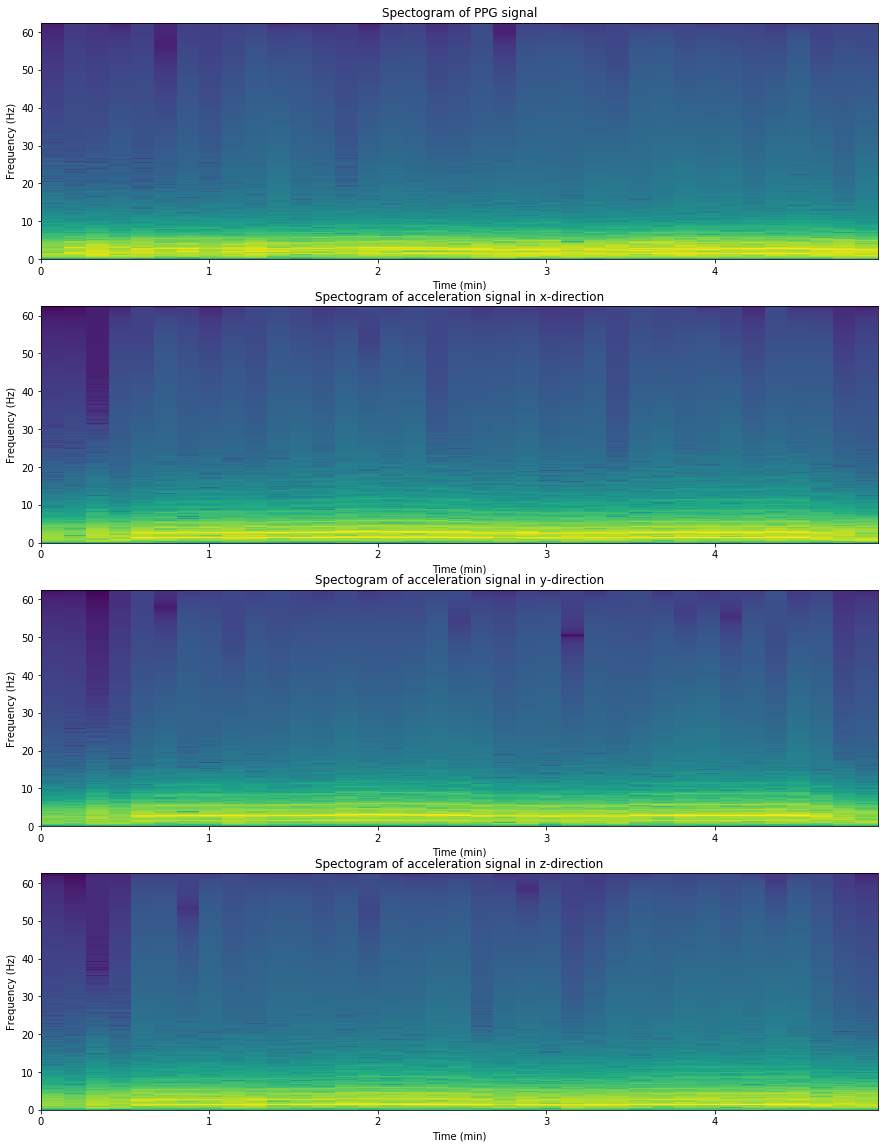

In [29]:
fig, axs = plt.subplots(4, figsize=(15, 20))

axs[0].specgram(filtered_sample_ppg, Fs=fs, NFFT=window_length, noverlap=overlap, xextent=[0, len(sample_ppg) / fs / 60])
axs[0].set_xlabel("Time (min)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title('Spectogram of PPG signal')

axs[1].specgram(filtered_sample_accx, Fs=fs, NFFT=window_length, noverlap=overlap, xextent=[0, len(sample_ppg) / fs / 60])
axs[1].set_xlabel("Time (min)")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_title('Spectogram of acceleration signal in x-direction')

axs[2].specgram(filtered_sample_accy, Fs=fs, NFFT=window_length, noverlap=overlap, xextent=[0, len(sample_ppg) / fs / 60])
axs[2].set_xlabel("Time (min)")
axs[2].set_ylabel("Frequency (Hz)")
axs[2].set_title('Spectogram of acceleration signal in y-direction')

axs[3].specgram(filtered_sample_accz, Fs=fs, NFFT=window_length, noverlap=overlap, xextent=[0, len(sample_ppg) / fs / 60])
axs[3].set_xlabel("Time (min)")
axs[3].set_ylabel("Frequency (Hz)")
axs[3].set_title('Spectogram of acceleration signal in z-direction')

In [6]:
evaluate =Evaluate()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

**Code Description**

The code is devided into three sections:
-  **Provided code**, which includes all the functions that were provided by udacity as starter code
-  **Visualizations** to explore the data
-  **Student code**, which includes `RunPulseRateAlgorithm` function that is the main function that alls all of the other support functions
    
To run the code correctly, you should include the data in the directory `./datasets/troika/training_data`, and make sure that all of the included libraries are installed. You can call the function `Evaluate()` to run the code. 

**Data Description**

Citation:
> **Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015.**

Description:

> Two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals were simultaneously recorded from subjects with age from 18 to 35. For each subject, the PPG signals were recorded from wrist by two pulse oximeters with green LEDs (wavelength: 515nm). Their distance (from center to center) was 2 cm. The acceleration signal was also recorded from wrist by a three-axis accelerometer. Both the pulse oximeter and the accelerometer were embedded in a wristband, which was comfortably worn. The ECG signal was recorded simultaneously from the chest using wet ECG sensors. All signals were sampled at 125 Hz and sent to a nearby computer via Bluetooth.

> Each dataset with the similar name `DATA_01_TYPE01` contains a variable `sig`. It has 6 rows. The first row is a simultaneous recording of ECG, which is recorded from the chest of each subject. The second row and the third row are two channels of PPG, which are recorded from the wrist of each subject. The last three rows are simultaneous recordings of acceleration data (in x-, y-, and z-axis).

>For each dataset with the similar name `DATA_01_TYPE01`, the ground-truth of heart rate can be calculated from the simultaneously recorded ECG signal (i.e. the first row of the variable `sig`). For convenience, we also provide the calculated ground-truth heart rate, stored in the datasets with the corresponding name, say `REF_01_TYPE01`. In each of this kind of datasets, there is a variable `BPM0`, which gives the BPM value in every 8-second time window. Note that two successive time windows overlap by 6 seconds. Thus the first value in 'BPM0' gives the calcualted heart rate ground-truth in the first 8 seconds, while the second value in 'BPM0' gives the calculated heart rate ground-truth from the 3rd second to the 10th second.

**Algorithhm Description**

The steps of the algorithm will be as follow:

- Extract the signals using the LoadTroikaDataFile function. The signals extracted are:
    - **ppg**: signal coming from the PPG sensor.
    - **accx**: Accelerometer signal in the X-direction.
    - **accy**: Accelerometer signal in the Y-direction.
    - **accz**: Accelerometer signal in the Z-direction.


- Extract the target ground truth
    - **ecg**: signal coming from the ECG measurements. BPM0 variables


- Set Parameters for our model
    - **fs**: sample rate or frequency sample(this data was provided with the dataset) fs = 125 [Hz]
    - **Min and Max BPM range**: as pulse rate will be restricted between 40BPM (beats per minute) and 240BPM


- Apply a bandpass filter to the PPG signal and to the ACC magnitude signal. 


- Featurize the bandpass filtered accelerometer signals within each specified window to get Fourier transforms, their peak values, the frequencies, and energies.


- Estimate pulse rate from the PPG signal and a 3-axis accelerometer, compares them with the gorund truth, compute the associated errors and estimation confidence for a given data_file and reference_file.


**Algorithm Performance**

Mean Absolute error (MAE) was used as a metric to compute the performance of the algorithm. The MAE was calculated by comparing heart rates estimated in 8s window with the given reference measurement (ground truth) in the same window length. The algorithm's MAE was 9.34 which is within the 15bpm required margin.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 